In [1]:
%load_ext autoreload

%autoreload 2


In [4]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import yfinance as yf
from tqdm import tqdm

while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df
from src.preprocessing.sentiment import generate_sentiment_from_title

api_key = '64d11b117233d0.77790833'

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

2023-08-16 21:29:37.319247: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 21:29:37.369020: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 21:29:37.369594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 21:29:38.672526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data acquisition

In [4]:
start_year = 2019
end_year = 2023
stock = "TSLA"

tesla_news, tesla_complete = get_news(stock)

100%|██████████| 12/12 [00:58<00:00,  4.89s/it]


In [6]:
len(tesla_complete)

19785

In [8]:
news_with_tesla = filter_news_with_name(tesla_complete, 'Tesla')

In [10]:
len(news_with_tesla)

9168

In [12]:
sentiment_tesla = generate_sentiment_from_title(
    news_with_tesla,
    tokenizer,
    finbert
)

  0%|          | 0/9168 [00:00<?, ?it/s]

100%|██████████| 9168/9168 [11:17<00:00, 13.54it/s]


In [18]:
tesla_df = pd.DataFrame(news_with_tesla)[["date","title","content"]]

In [20]:
tesla_df["sentiment"] = sentiment_tesla

In [23]:
save_company_news_df(tesla_df,
                     "tesla")

## Price analysis

In [6]:
tesla_df = read_company_news_df("tesla")

In [39]:
tesla_prices = yf.download(
    'TSLA',
    start='2019-12-30',
    end='2022-12-30'
)

[*********************100%***********************]  1 of 1 completed


In [70]:
tesla_prices.index = pd.to_datetime(tesla_prices.index)

In [71]:
tesla_prices

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-30,28.586000,28.600000,27.284000,27.646667,27.646667,188796000
2019-12-31,27.000000,28.086000,26.805332,27.888666,27.888666,154285500
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
...,...,...,...,...,...,...
2022-12-22,136.000000,136.630005,122.260002,125.349998,125.349998,210090300
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400


In [72]:
tesla_df["date"] = pd.to_datetime(tesla_df["date"])
tesla_df["date"] = tesla_df["date"].dt.date

In [73]:
tesla_df = tesla_df\
    .drop_duplicates(subset = "title")

In [74]:
tesla_df["sentiment_count"] = tesla_df["sentiment"].map({
    "neutral": 0 ,
    "positive" : 1,
    "negative" : -1
})

In [75]:
tesla_sentiment = tesla_df.groupby("date")\
    .sum()\
    .sentiment_count

/tmp/ipykernel_16186/3228740504.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()\


In [89]:
tesla_sentiment.index = pd.to_datetime(tesla_sentiment.index)

<Axes: xlabel='date'>

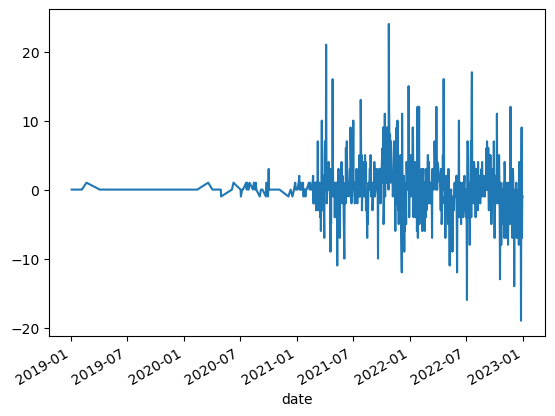

In [90]:
tesla_sentiment.plot()

In [109]:
median_sentiment = tesla_sentiment\
    .dropna()

In [122]:
tesla_sentiment = tesla_sentiment.dropna()

In [124]:
def zscore(x: pd.Series):
    return (x - x.mean())/x.std()

tesla_sentiment_zscore = zscore(tesla_sentiment)

<Axes: >

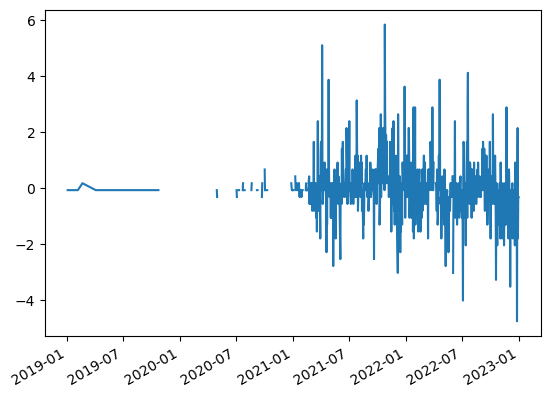

In [131]:
tesla_sentiment_zscore.plot()

In [111]:
tesla_prices


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-30,28.586000,28.600000,27.284000,27.646667,27.646667,188796000
2019-12-31,27.000000,28.086000,26.805332,27.888666,27.888666,154285500
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
...,...,...,...,...,...,...
2022-12-22,136.000000,136.630005,122.260002,125.349998,125.349998,210090300
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400


In [132]:
tesla_sentiment_zscore.index

DatetimeIndex(['2019-01-02', '2019-01-19', '2019-01-30', '2019-02-04',
               '2019-02-19', '2019-04-03', '2019-04-04', '2019-04-10',
               '2019-04-11', '2019-04-24',
               ...
               '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
               '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30',
               '2022-12-31', '2023-01-01'],
              dtype='datetime64[ns]', length=961, freq=None)

In [113]:
tesla_prices_close = tesla_prices.Close

In [114]:
tesla_prices_close.index

DatetimeIndex(['2019-12-30', '2019-12-31', '2020-01-02', '2020-01-03',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-13',
               ...
               '2022-12-15', '2022-12-16', '2022-12-19', '2022-12-20',
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-27',
               '2022-12-28', '2022-12-29'],
              dtype='datetime64[ns]', name='Date', length=757, freq=None)

In [126]:
new_idx = tesla_sentiment_zscore\
    .index\
    .union(tesla_prices.index)

In [127]:
tesla_sentiment_zscore = tesla_sentiment_zscore.reindex(index = new_idx)
tesla_prices_close = tesla_prices_close.reindex(index = new_idx)

In [133]:
tesla_prices_close = tesla_prices_close.ffill()
tesla_sentiment_zscore = tesla_sentiment_zscore.ffill()

<Axes: >

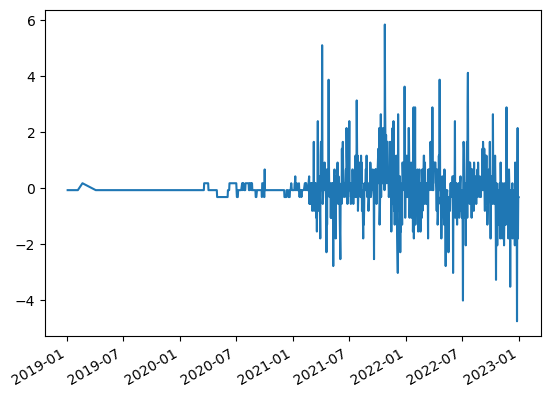

In [134]:
tesla_sentiment_zscore.plot()

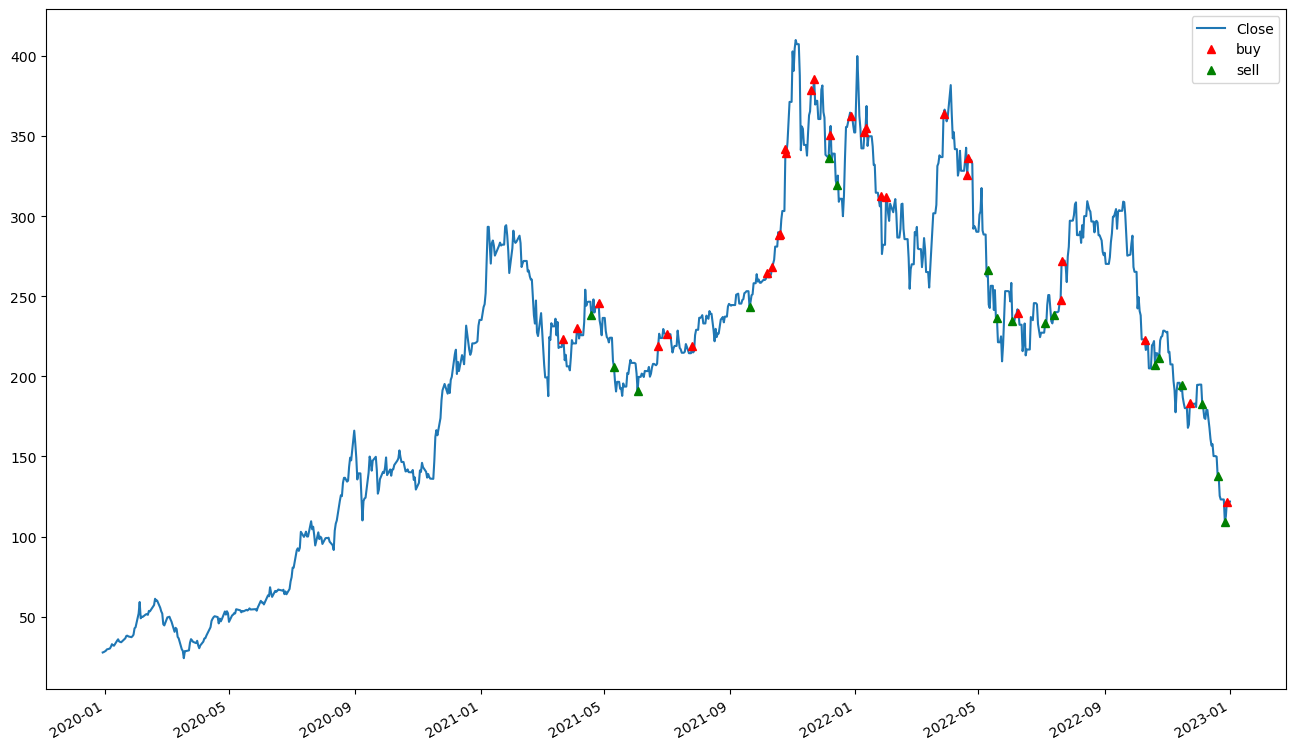

In [135]:
plt.figure(figsize=(16,10))
tesla_prices_close.plot()
tesla_prices_close[tesla_sentiment_zscore > 2].plot(
    color = 'red',
    marker = '^',
    linestyle = "None",
    label = "buy"
)

tesla_prices_close[tesla_sentiment_zscore < -2].plot(
    color = 'green',
    marker = '^',
    linestyle = "None",
    label = "sell"
)

plt.legend()
plt.show()

In [136]:
from sklearn.linear_model import LinearRegression

In [176]:
x = tesla_sentiment
y = tesla_prices_close.pct_change(-5)

In [177]:
y = y.dropna()

In [184]:
x= x.reindex_like(y)\
    .ffill()\
    .fillna(value = 0)

In [186]:
y

2019-12-30   -0.115891
2019-12-31   -0.149978
2020-01-02   -0.106120
2020-01-03   -0.073492
2020-01-06   -0.139694
                ...   
2022-12-23    0.092627
2022-12-24    0.010918
2022-12-25    0.010918
2022-12-26    0.010918
2022-12-27   -0.104416
Name: Close, Length: 936, dtype: float64

In [187]:
x

2019-12-30     0.0
2019-12-31     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-06     0.0
              ... 
2022-12-23    -6.0
2022-12-24    -1.0
2022-12-25    -1.0
2022-12-26    -3.0
2022-12-27   -19.0
Name: sentiment_count, Length: 936, dtype: float64

In [188]:
model = LinearRegression()
model.fit(
    pd.DataFrame(x), 
    y
)

LinearRegression()

In [189]:
model.coef_

array([-0.00034375])